<a href="https://colab.research.google.com/github/aaronsouza/VAE-SynDataAn/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openpyxl
!pip install kagglehub

In [ ]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Download the latest version of the dataset
path = kagglehub.dataset_download("shreyasinha/dataset-containing-antenna-parameters")
print("Path to dataset files:", path)

# List files in the downloaded dataset directory
print("Files in dataset:", os.listdir(path))

# Replace 'filename.csv' with the actual file name from the dataset
file_path = os.path.join(path, "dataset_antenna.csv")
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())

# Data description
print(data.describe())

Path to dataset files: /root/.cache/kagglehub/datasets/shreyasinha/dataset-containing-antenna-parameters/versions/1
Files in dataset: ['dataset_antenna.csv']
   Freq(GHz)  length of patch in mm  width of patch in mm  Slot length in mm  \
0   1.500000                   33.0                    33                0.0   
1   1.551724                   33.0                    33                0.0   
2   1.603448                   33.0                    33                0.0   
3   1.655172                   33.0                    33                0.0   
4   1.706897                   33.0                    33                0.0   

   slot width in mm   s11(dB)  
0                 0 -4.927274  
1                 0 -5.077877  
2                 0 -5.183708  
3                 0 -5.215997  
4                 0 -5.120009  
         Freq(GHz)  length of patch in mm  width of patch in mm  \
count  1266.000000            1266.000000           1266.000000   
mean      2.408768              39.

In [ ]:
# Identify categorical columns
cols = data.columns[data.dtypes == object]
print("Categorical columns:", cols)

# Analyze categorical columns
for col in cols:
    print(col)
    print(data[col].value_counts())
    print('******************************')
    print()

# Drop categorical columns
df = data.drop(cols, axis=1)

Categorical columns: Index([], dtype='object')


In [ ]:
# Normalize the data
norm_df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)
print(norm_df.head())

# Check GPU availability
tensorflow.config.run_functions_eagerly(True)
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

# Define model parameters
img_size_1 = df.shape[1]  # Number of features in the dataset
latent_space_dim = 2

   Freq(GHz)  length of patch in mm  width of patch in mm  Slot length in mm  \
0   0.200000                 0.0625              0.067308                0.0   
1   0.220690                 0.0625              0.067308                0.0   
2   0.241379                 0.0625              0.067308                0.0   
3   0.262069                 0.0625              0.067308                0.0   
4   0.282759                 0.0625              0.067308                0.0   

   slot width in mm   s11(dB)  
0               0.0  0.861292  
1               0.0  0.856911  
2               0.0  0.853832  
3               0.0  0.852893  
4               0.0  0.855685  
Num GPUs Available:  0


In [ ]:
# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size_1, 1, 1), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = tensorflow.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tensorflow.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")

encoder.summary()

Model: "encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 6, 1, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_1 (Conv2D)   │ (None, 6, 1, 1)        │             10 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_norm_1            │ (None, 6, 1, 1)        │              4 │ encoder_conv_1[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_leakyrelu_1       │ (None, 6, 1, 1)        │              0 │ encoder_norm_1[0][0]   │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_2 (Conv2D)   │ (None, 6, 1, 32)       │            320 │ encoder_leakyrelu_1[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_norm_2            │ (None, 6, 1, 32)       │            128 │ encoder_conv_2[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_activ_layer_2     │ (None, 6, 1, 32)       │              0 │ encoder_norm_2[0][0]   │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_3 (Conv2D)   │ (None, 3, 1, 64)       │         18,496 │ encoder_activ_layer_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_norm_3            │ (None, 3, 1, 64)       │            256 │ encoder_conv_3[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_activ_layer_3     │ (None, 3, 1, 64)       │              0 │ encoder_norm_3[0][0]   │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_4 (Conv2D)   │ (None, 2, 1, 64)       │         36,928 │ encoder_activ_layer_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_norm_4            │ (None, 2, 1, 64)       │            256 │ encoder_conv_4[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_activ_layer_4     │ (None, 2, 1, 64)       │              0 │ encoder_norm_4[0][0]   │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_5 (Conv2D)   │ (None, 2, 1, 64)       │         36,928 │ encoder_activ_layer_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_norm_5            │ (None, 2, 1, 64)       │            256 │ encoder_conv_5[0][0]   │
│ (BatchNormalization) 

 Total params: 94,098 (367.57 KB)

 Trainable params: 93,648 (365.81 KB)

 Non-trainable params: 450 (1.76 KB)

In [ ]:
# Decoder
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim,), name="decoder_input")

decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=384, name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=(6,1,64))(decoder_dense_layer1)

decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(2, 2), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )
decode = tensorflow.keras.layers.Reshape(target_shape=(6,1,1))
decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")

decoder.summary()


Model: "decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense_1 (Dense)              │ (None, 384)                 │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 6, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_tran_1                  │ (None, 6, 1, 64)            │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_norm_1 (BatchNormalization)  │ (None, 6, 1, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_leakyrelu_1 (LeakyReLU)      │ (None, 6, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_tran_2                  │ (None, 6, 1, 64)            │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_norm_2 (BatchNormalization)  │ (None, 6, 1, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_leakyrelu_2 (LeakyReLU)      │ (None, 6, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_tran_3                  │ (None, 6, 1, 64)            │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_norm_3 (BatchNormalization)  │ (None, 6, 1, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_leakyrelu_3 (LeakyReLU)      │ (None, 6, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_tran_4                  │ (None, 6, 1, 1)             │             257 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (LeakyReLU)           │ (None, 6, 1, 1)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,961 (441.25 KB)

 Trainable params: 112,577 (439.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Loss function
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [ ]:
# VAE model
vae_input = tensorflow.keras.layers.Input(shape=(img_size_1, 1, 1), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ VAE_input (InputLayer)               │ (None, 6, 1, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_model (Functional)           │ (None, 2)                   │          94,098 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_model (Functional)           │ (None, 6, 1, 1)             │         112,961 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207,059 (808.82 KB)

 Trainable params: 206,225 (805.57 KB)

 Non-trainable params: 834 (3.26 KB)

In [ ]:
# Compile the model
vae.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

In [ ]:
# Reshape the data for the model
reshaped_array = np.array(norm_df).reshape(-1, img_size_1, 1, 1)
print(reshaped_array.shape)

(1266, 6, 1, 1)


In [ ]:
# Train the model
vae.fit(reshaped_array, reshaped_array, epochs=1, batch_size=10, shuffle=True)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 40s 308ms/step - loss: 77.2636


In [ ]:
# Passing any random 2 numbers to decoder
z_sample = np.array([[-1, 0.6]])
print(decoder.predict(z_sample))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[[[[0.20007132]]

  [[0.07089785]]

  [[0.07083435]]

  [[0.12196252]]

  [[0.1323574 ]]

  [[0.21819435]]]]


In [31]:
num_data_points = data.shape[0]
num_features = data.shape[1]

print(f"Number of data points: {num_data_points}")
print(f"Number of features: {num_features}")

Number of data points: 1266
Number of features: 6


In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming norm_df is already defined (normalized DataFrame)
# If not, normalize your data first
scaler = MinMaxScaler()
norm_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Define col_index
col_index = {i: col for i, col in enumerate(norm_df.columns)}

# Generate synthetic data
scale = 1.0
n = 10
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)

synthetic_data = []
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        synthetic_data.append(x_decoded[0])

# Reshape synthetic data and create DataFrame
syn_data = np.array(synthetic_data).reshape(-1, norm_df.shape[1])
synth_data = pd.DataFrame(syn_data, columns=col_index.values())

# Display the synthetic data
print(synth_data.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━

In [36]:
#SYNDATA STATISTICS
# Display summary statistics
print(synth_data.describe())

        Freq(GHz)  length of patch in mm  width of patch in mm  \
count  100.000000             100.000000            100.000000   
mean     0.182644               0.103429              0.131801   
std      0.012676               0.020174              0.030583   
min      0.158470               0.058122              0.067853   
25%      0.172585               0.086964              0.110318   
50%      0.183894               0.104484              0.134396   
75%      0.194046               0.120475              0.154921   
max      0.201967               0.138970              0.192736   

       Slot length in mm  slot width in mm     s11(dB)  
count         100.000000        100.000000  100.000000  
mean            0.145207          0.142752    0.187130  
std             0.013446          0.010526    0.017833  
min             0.118736          0.130259    0.159042  
25%             0.133283          0.135407    0.172493  
50%             0.149206          0.139154    0.184073  
75%   

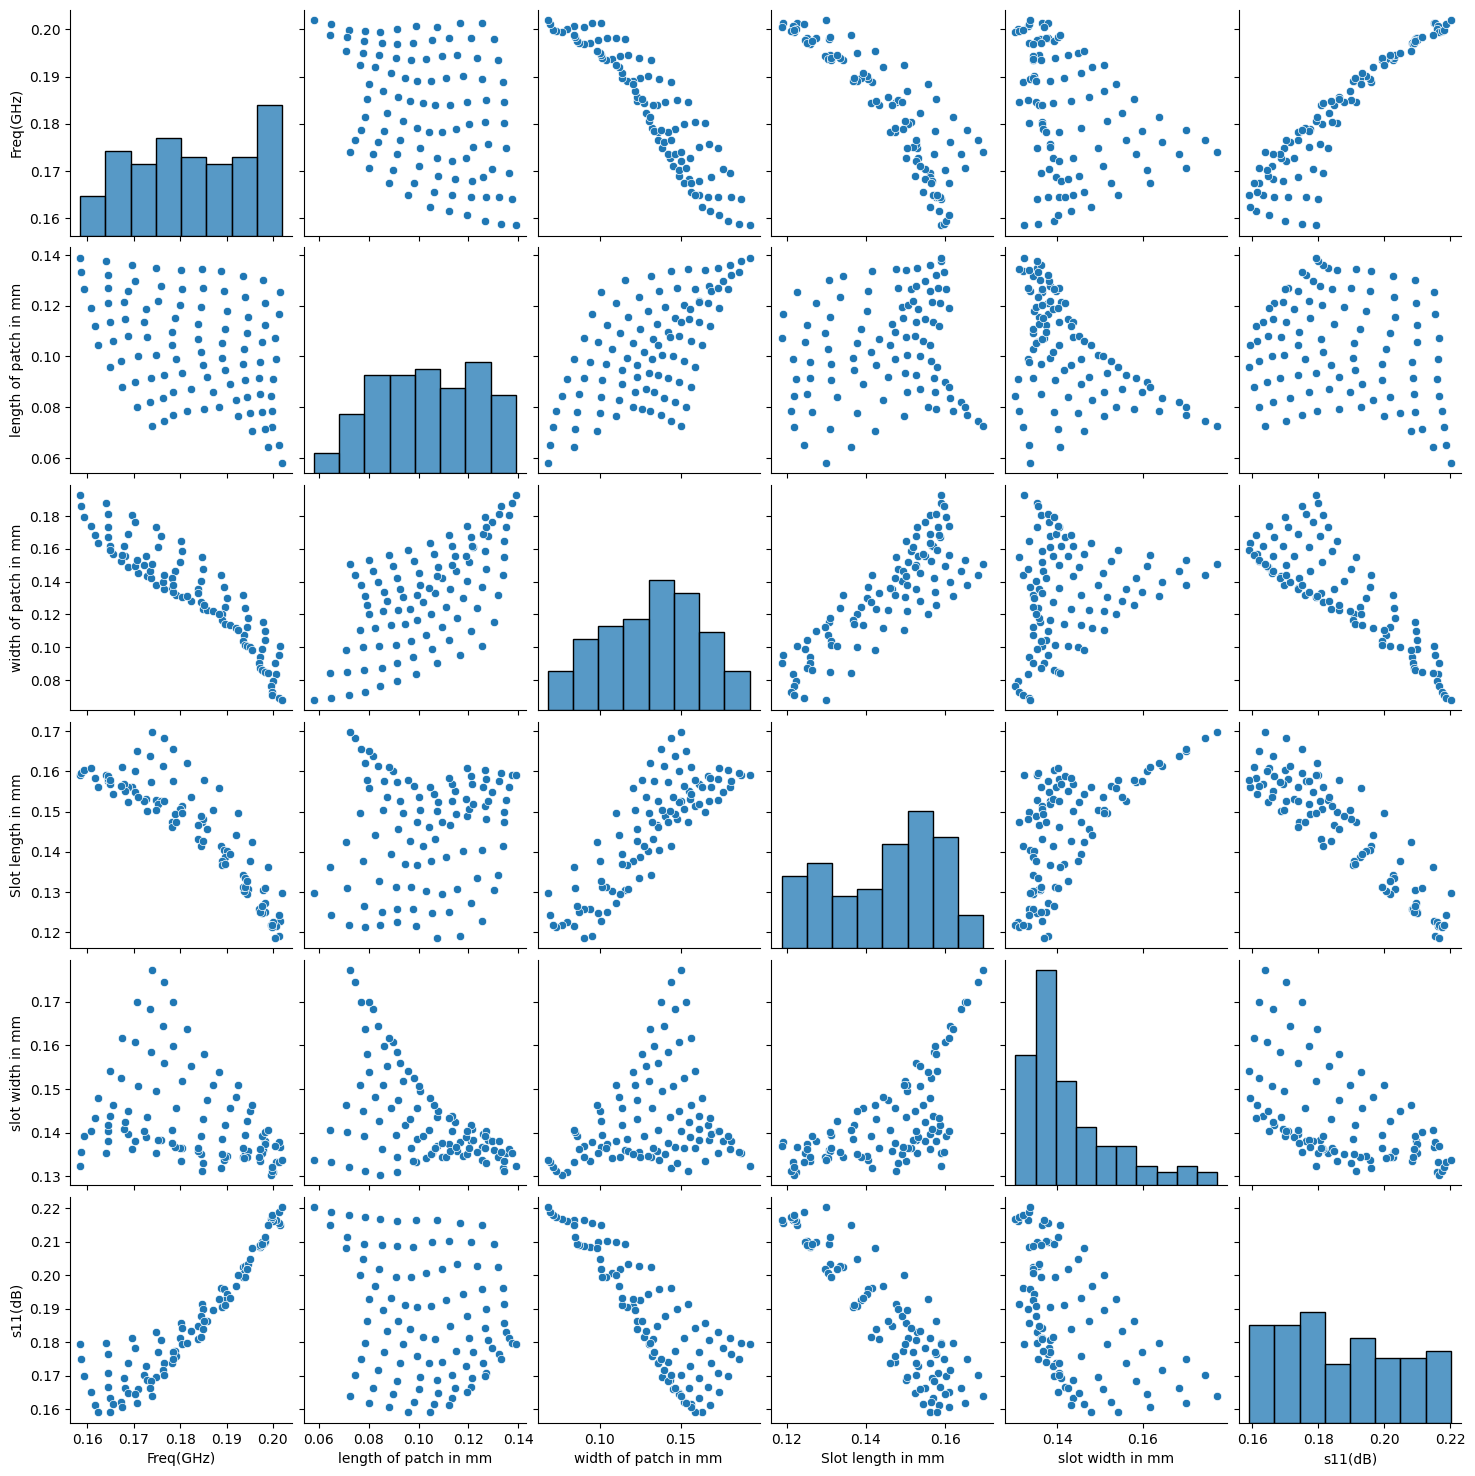

In [37]:
#SYNDATA VISUALISATION
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pairplot
sns.pairplot(synth_data)
plt.show()

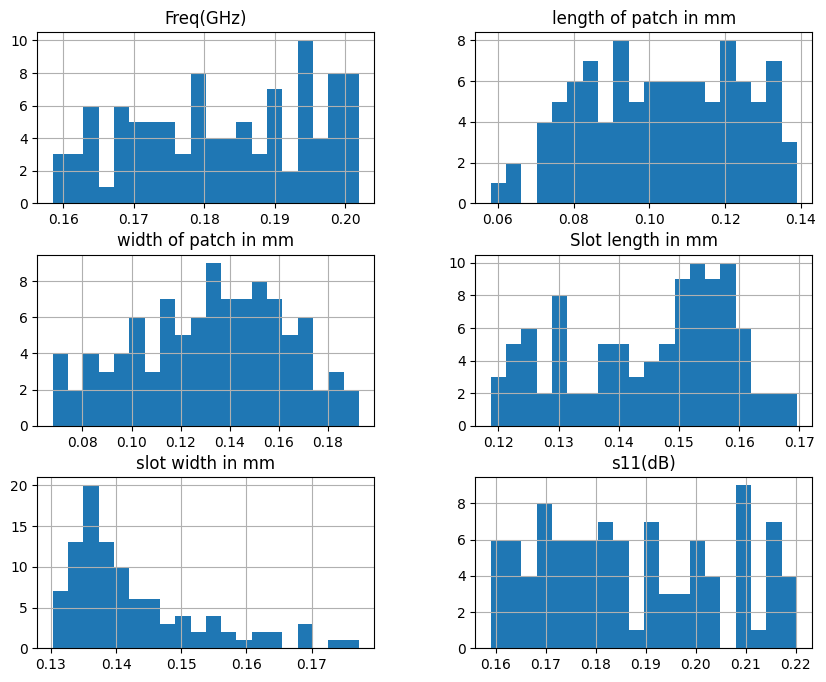

In [38]:
#HISTOGRAMS
# Plot histograms for all features
synth_data.hist(bins=20, figsize=(10, 8))
plt.show()

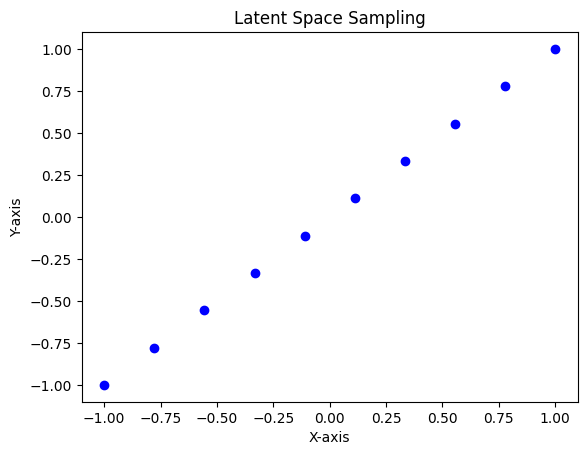

In [39]:
#SCATTERING ON 2D LATENT SPACE
# Plot the latent space grid
plt.scatter(grid_x, grid_y, c='blue', marker='o')
plt.title("Latent Space Sampling")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()